# Test the model of PCA+logistic regression

In [1]:
from cnn_utils import *
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
from keras.optimizers import Adam
import seaborn as sns
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

ModuleNotFoundError: No module named 'cnn_utils'

In [2]:
df = create_dataframe('/../raw_data/dataset_071220.json',image_size=(25,50))
df.head()

,eyeImage,leftEye,rightEye,y
0,"[[[0.43529411764705883, 0.41568627450980394, 0...","[-0.06916704732662149, 0.19730078279591035, -0...","[0.17425771877389162, 0.21639015714266296, 0.2...","[-0.30000000000000004, -0.3019517795637199]"
1,"[[[0.15294117647058825, 0.12156862745098039, 0...","[-0.17658285534307594, 0.18033866676032262, -0...","[0.06629549190581052, 0.1988126179958256, 0.10...","[0.30000000000000004, -0.9012629161882894]"
2,"[[[0.1607843137254902, 0.13333333333333333, 0....","[-0.17382043840055927, 0.17981051564675177, -0...","[0.06089991895895852, 0.18628686237123016, 0.0...","[0.8999999999999999, -0.9012629161882894]"
3,"[[[0.17254901960784313, 0.12941176470588237, 0...","[-0.15968611544730582, 0.18524077990937093, -0...","[0.08123800929222913, 0.1904861112443328, 0.11...","[-0.30000000000000004, 0.8989667049368542]"
4,"[[[0.4980392156862745, 0.4627450980392157, 0.5...","[-0.07825260742468576, 0.16963032408957468, -0...","[0.1666792245722788, 0.19617187288354976, 0.20...","[-0.30000000000000004, 0.2996555683122848]"


## 1. Get to know how many dimension we need to capture 99% of variance

In [3]:
first_idx = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(df.loc[:,df.columns!="y"],df.loc[:,df.columns=="y"], test_size=0.3)

    eyeImage_train = np.stack(X_train['eyeImage'].to_numpy())
    eyeImage_test = np.stack(X_test['eyeImage'].to_numpy())
    
    # reshape to make it possible to feed into SVM
    eyeImage_train = eyeImage_train.reshape(eyeImage_train.shape[0],eyeImage_train.shape[1]*eyeImage_train.shape[2]*eyeImage_train.shape[3])
    eyeImage_test = eyeImage_test.reshape(eyeImage_test.shape[0],eyeImage_test.shape[1]*eyeImage_test.shape[2]*eyeImage_test.shape[3])
    pca = PCA(n_components=150, whiten=True, random_state=42)
    
    train_score = svm_model.score(eyeImage_train, y_train_binary, sample_weight=None)
    test_score = svm_model.score(eyeImage_test, y_test_binary, sample_weight=None)

    pca.fit(eyeImage_train)
    
    first_idx.append(np.where(pca.explained_variance_ratio_.cumsum() > 0.99)[0][0])

NameError: name 'svm_model' is not defined

In [ ]:
np.mean(first_idx)

In [ ]:
np.std(first_idx)

In [ ]:
pca.transform(eyeImage_train).shape

### Conclusion: in the 100 iterations, the mean of the first index that explains 99%+ variation is 117.38, with a std of 1.074988372030135. Thus, having 125 dimension would be sufficient in our case

## 2.  Experiment with adding left/right eye positions

Do not need to scale images before feeding into PCA as the previous experiments shows the performance is similar.

### Find the best C for this task

In [150]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,df.columns!="y"],df.loc[:,df.columns=="y"], test_size=0.01)

y_train_binary = create_binary_labels(y_train)
y_test_binary = create_binary_labels(y_test)

eyeImage_train = np.stack(X_train['eyeImage'].to_numpy())
eyeImage_test = np.stack(X_test['eyeImage'].to_numpy())

leftEye_train = np.stack(X_train['leftEye'].to_numpy())
leftEye_test = np.stack(X_test['leftEye'].to_numpy())

rightEye_train = np.stack(X_train['rightEye'].to_numpy())
rightEye_test = np.stack(X_test['rightEye'].to_numpy())

# reshape to make it possible to feed into SVM
eyeImage_train = eyeImage_train.reshape(eyeImage_train.shape[0],eyeImage_train.shape[1]*eyeImage_train.shape[2]*eyeImage_train.shape[3])
eyeImage_test = eyeImage_test.reshape(eyeImage_test.shape[0],eyeImage_test.shape[1]*eyeImage_test.shape[2]*eyeImage_test.shape[3])

# model part
pca = PCA(n_components=125, whiten=True)
scalar = StandardScaler()
logit = LogisticRegression(solver='saga')

# prepare the input training data
pca.fit(eyeImage_train)
eyeImage_train = pca.transform(eyeImage_train)
input_train = np.concatenate((eyeImage_train, leftEye_train, rightEye_train), axis=1)
# input_train =eyeImage_train
scalar.fit(input_train)
input_train = scalar.transform(input_train)

grid = GridSearchCV(estimator=logit, param_grid={'C':[i*0.01 for i in range(1,100)],
                                                'penalty':['l1']})
grid.fit(input_train, y_train_binary)
# svc.fit(input_train, y_train_binary)
# train_score = svc.score(input_train, y_train_binary, sample_weight=None)


# # prepare the input testing data
# eyeImage_test = pca.transform(eyeImage_test)
# input_test = np.concatenate((eyeImage_test, leftEye_test, rightEye_test), axis=1)
# # input_test =eyeImage_test
# input_test = scalar.transform(input_test)

# test_score = svc.score(input_test, y_test_binary, sample_weight=None)

GridSearchCV(estimator=LogisticRegression(solver='saga'),
             param_grid={'C': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08,
                               0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16,
                               0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24,
                               0.25, 0.26, 0.27, 0.28, 0.29, 0.3, ...],
                         'penalty': ['l1']})

In [152]:
grid.best_score_

0.9180851063829788

In [149]:
from scipy import stats
 
stats.mode(Cs)[0][0]

0.02

In [153]:
def test_robustness(df):
    """
    For testing the robustness of our PCA+SVM model when we split the train and test randomly
    """
    train_scores, test_scores = [], []
    for i in range(50):
        X_train, X_test, y_train, y_test = train_test_split(df.loc[:,df.columns!="y"],df.loc[:,df.columns=="y"], test_size=0.3)

        eyeImage_train = np.stack(X_train['eyeImage'].to_numpy())
        eyeImage_test = np.stack(X_test['eyeImage'].to_numpy())
        y_train_binary = create_binary_labels(y_train)
        y_test_binary = create_binary_labels(y_test)

        # reshape to make it possible to feed into SVM
        eyeImage_train = eyeImage_train.reshape(eyeImage_train.shape[0],eyeImage_train.shape[1]*eyeImage_train.shape[2]*eyeImage_train.shape[3])
        eyeImage_test = eyeImage_test.reshape(eyeImage_test.shape[0],eyeImage_test.shape[1]*eyeImage_test.shape[2]*eyeImage_test.shape[3])
        pca = PCA(n_components=125, whiten=True, random_state=42)
        logit = LogisticRegression(penalty='l1', solver='saga',C=0.2)
        svm_model = make_pipeline(pca, svc)
        svm_model.fit(eyeImage_train, y_train_binary)
        # param_grid = {'svc__C': [100,50,10,5,1,0.5,0.1, 0.05, 0.01, 0.005, 0.001]}
        # grid = GridSearchCV(svm_model, param_grid)
        # %time grid.fit(eyeImage_train, y_train_binary)
        # print(grid.best_params_)

        # svm_model = grid.best_estimator_

        train_score = svm_model.score(eyeImage_train, y_train_binary, sample_weight=None)
        test_score = svm_model.score(eyeImage_test, y_test_binary, sample_weight=None)

        train_scores.append(train_score)
        test_scores.append(test_score)
        svm_model = None

    data = {'train_score':train_scores, 'test_score':test_scores}

    return pd.DataFrame(data)

In [154]:
logit_df = test_robustness(df)

Text(0.5, 1.0, 'Acc of PCA+logitL1 in 100 rand splits')

<Figure size 432x288 with 0 Axes>

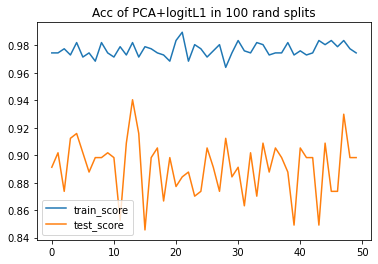

In [155]:
plt.figure()
logit_df.plot()
plt.legend(loc="best")
plt.title("Acc of PCA+logitL1 in 100 rand splits")
# plt.savefig("./results/PCA_SVM_eye_acc_0716.png")

In [156]:
logit_df.mean(axis=0)

train_score    0.976481
test_score     0.891368
dtype: float64

In [157]:
logit_df.std(axis=0)

train_score    0.004999
test_score     0.020162
dtype: float64

In [158]:
def pca_svm_positions_robustness(df):
    train_scores, test_scores = [], []
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(df.loc[:,df.columns!="y"],df.loc[:,df.columns=="y"], test_size=0.2)

        y_train_binary = create_binary_labels(y_train)
        y_test_binary = create_binary_labels(y_test)

        eyeImage_train = np.stack(X_train['eyeImage'].to_numpy())
        eyeImage_test = np.stack(X_test['eyeImage'].to_numpy())

        leftEye_train = np.stack(X_train['leftEye'].to_numpy())
        leftEye_test = np.stack(X_test['leftEye'].to_numpy())

        rightEye_train = np.stack(X_train['rightEye'].to_numpy())
        rightEye_test = np.stack(X_test['rightEye'].to_numpy())

        # reshape to make it possible to feed into SVM
        eyeImage_train = eyeImage_train.reshape(eyeImage_train.shape[0],eyeImage_train.shape[1]*eyeImage_train.shape[2]*eyeImage_train.shape[3])
        eyeImage_test = eyeImage_test.reshape(eyeImage_test.shape[0],eyeImage_test.shape[1]*eyeImage_test.shape[2]*eyeImage_test.shape[3])

        # model part
        pca = PCA(n_components=125, whiten=True)
        scalar = StandardScaler()
        svc = LogisticRegression(penalty='l1',solver='saga',C=0.2) #SVC(kernel='linear', C=0.1)

        # prepare the input training data
        pca.fit(eyeImage_train)
        eyeImage_train = pca.transform(eyeImage_train)
        input_train = np.concatenate((eyeImage_train, leftEye_train, rightEye_train), axis=1)
        # input_train =eyeImage_train
        scalar.fit(input_train)
        input_train = scalar.transform(input_train)


        svc.fit(input_train, y_train_binary)
        train_score = svc.score(input_train, y_train_binary, sample_weight=None)


        # prepare the input testing data
        eyeImage_test = pca.transform(eyeImage_test)
        input_test = np.concatenate((eyeImage_test, leftEye_test, rightEye_test), axis=1)
        # input_test =eyeImage_test
        input_test = scalar.transform(input_test)

        test_score = svc.score(input_test, y_test_binary, sample_weight=None)

        svc,pca, scalar = None, None, None
        train_scores.append(train_score)
        test_scores.append(test_score)

    data = {'train_score':train_scores, 'test_score':test_scores}

    return pd.DataFrame(data)

In [159]:
position_df = pca_svm_positions_robustness(df)

In [160]:
position_df.mean(axis=0)

train_score    0.968039
test_score     0.912895
dtype: float64

In [161]:
position_df.std(axis=0)

train_score    0.004813
test_score     0.018006
dtype: float64

Text(0.5, 1.0, 'Acc of PCA+SVM+eyePosition in 100 rand splits')

<Figure size 432x288 with 0 Axes>

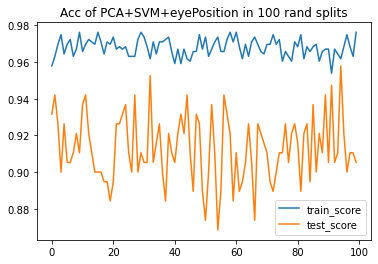

In [162]:
plt.figure()
position_df.plot()
plt.legend(loc="best")
plt.title("Acc of PCA+SVM+eyePosition in 100 rand splits")
# plt.savefig("./results/PCA_SVM_eye_acc_0716.png")

### Without using eye positions information

In [113]:
def pca_svm_positions_robustness(df):
    train_scores, test_scores = [], []
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(df.loc[:,df.columns!="y"],df.loc[:,df.columns=="y"], test_size=0.2)

        y_train_binary = create_binary_labels(y_train)
        y_test_binary = create_binary_labels(y_test)

        eyeImage_train = np.stack(X_train['eyeImage'].to_numpy())
        eyeImage_test = np.stack(X_test['eyeImage'].to_numpy())

        leftEye_train = np.stack(X_train['leftEye'].to_numpy())
        leftEye_test = np.stack(X_test['leftEye'].to_numpy())

        rightEye_train = np.stack(X_train['rightEye'].to_numpy())
        rightEye_test = np.stack(X_test['rightEye'].to_numpy())

        # reshape to make it possible to feed into SVM
        eyeImage_train = eyeImage_train.reshape(eyeImage_train.shape[0],eyeImage_train.shape[1]*eyeImage_train.shape[2]*eyeImage_train.shape[3])
        eyeImage_test = eyeImage_test.reshape(eyeImage_test.shape[0],eyeImage_test.shape[1]*eyeImage_test.shape[2]*eyeImage_test.shape[3])

        # model part
        pca = PCA(n_components=125, whiten=True)
        # scalar = StandardScaler()
        svc = SVC(kernel='linear', C=0.1)

        # prepare the input training data
        pca.fit(eyeImage_train)
        eyeImage_train = pca.transform(eyeImage_train)
        # input_train = np.concatenate((eyeImage_train, leftEye_train, rightEye_train), axis=1)
        input_train =eyeImage_train
        # scalar.fit(input_train)
        # input_train = scalar.transform(input_train)


        svc.fit(input_train, y_train_binary)
        train_score = svc.score(input_train, y_train_binary, sample_weight=None)


        # prepare the input testing data
        eyeImage_test = pca.transform(eyeImage_test)
        # input_test = np.concatenate((eyeImage_test, leftEye_test, rightEye_test), axis=1)
        input_test =eyeImage_test
        # input_test = scalar.transform(input_test)

        test_score = svc.score(input_test, y_test_binary, sample_weight=None)

        svc,pca, scalar = None, None, None
        train_scores.append(train_score)
        test_scores.append(test_score)

    data = {'train_score':train_scores, 'test_score':test_scores}

    return pd.DataFrame(data)

In [114]:
position_df = pca_svm_positions_robustness(df)

In [115]:
position_df.mean(axis=0)

train_score    0.972329
test_score     0.898947
dtype: float64

In [116]:
position_df.std(axis=0)

train_score    0.004751
test_score     0.018063
dtype: float64

Text(0.5, 1.0, 'Acc of PCA+SVM+eyePosition in 100 rand train-test splits')

<Figure size 432x288 with 0 Axes>

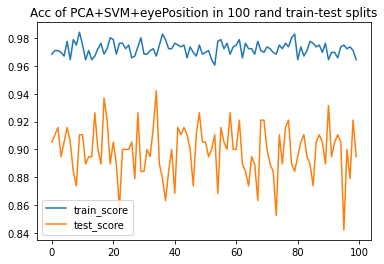

In [117]:
plt.figure()
position_df.plot()
plt.legend(loc="best")
plt.title("Acc of PCA+SVM+eyePosition in 100 rand train-test splits")

In [107]:
def test_robustness(df):
    """
    For testing the robustness of our PCA+SVM model when we split the train and test randomly
    """
    train_scores, test_scores = [], []
    for i in range(200):
        X_train, X_test, y_train, y_test = train_test_split(df.loc[:,df.columns!="y"],df.loc[:,df.columns=="y"], test_size=0.3)

        eyeImage_train = np.stack(X_train['eyeImage'].to_numpy())
        eyeImage_test = np.stack(X_test['eyeImage'].to_numpy())
        y_train_binary = create_binary_labels(y_train)
        y_test_binary = create_binary_labels(y_test)

        # reshape to make it possible to feed into SVM
        eyeImage_train = eyeImage_train.reshape(eyeImage_train.shape[0],eyeImage_train.shape[1]*eyeImage_train.shape[2]*eyeImage_train.shape[3])
        eyeImage_test = eyeImage_test.reshape(eyeImage_test.shape[0],eyeImage_test.shape[1]*eyeImage_test.shape[2]*eyeImage_test.shape[3])
        pca = PCA(n_components=125, whiten=True, random_state=42)
        svc = SVC(kernel='linear', C=0.1)
        svm_model = make_pipeline(pca, svc)
        svm_model.fit(eyeImage_train, y_train_binary)
        # param_grid = {'svc__C': [100,50,10,5,1,0.5,0.1, 0.05, 0.01, 0.005, 0.001]}
        # grid = GridSearchCV(svm_model, param_grid)
        # %time grid.fit(eyeImage_train, y_train_binary)
        # print(grid.best_params_)

        # svm_model = grid.best_estimator_

        train_score = svm_model.score(eyeImage_train, y_train_binary, sample_weight=None)
        test_score = svm_model.score(eyeImage_test, y_test_binary, sample_weight=None)

        train_scores.append(train_score)
        test_scores.append(test_score)
        svm_model = None

    data = {'train_score':train_scores, 'test_score':test_scores}

    return pd.DataFrame(data)

In [108]:
result_df = test_robustness(df)

In [109]:
result_df

,train_score,test_score
0,0.977444,0.845614
1,0.975940,0.894737
2,0.972932,0.894737
3,0.977444,0.901754
4,0.981955,0.863158
...,...,...
195,0.977444,0.901754
196,0.972932,0.915789
197,0.972932,0.863158
198,0.971429,0.898246


In [123]:
result_df.to_csv("results/pca_svm_cv.csv")

In [110]:
result_df.mean(axis=0)

train_score    0.975571
test_score     0.892000
dtype: float64

In [111]:
result_df.std(axis=0)

train_score    0.005017
test_score     0.016697
dtype: float64

In [11]:
y_train.index

NameError: name 'y_train' is not defined

In [12]:
print(classification_report(y_test_binary, yfit))
 

NameError: name 'y_test_binary' is not defined

In [13]:
yfit_train = svm_model.predict(eyeImage_train)
print(classification_report(y_train_binary, yfit_train))

NameError: name 'svm_model' is not defined

<Figure size 432x288 with 0 Axes>

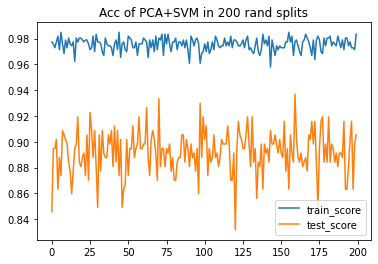

In [118]:
plt.figure()
result_df.plot()
plt.legend(loc="best")
plt.title("Acc of PCA+SVM in 200 rand splits")
plt.savefig("results/pca_svm_cv_acc_0716.png")

## 2. Only use far left and far right data

In [18]:
# create a extreme df
is_far_right = df["y"].map(lambda x: x[0]>0.7)
is_far_left = df["y"].map(lambda x: x[0]<-0.7)
df_extreme = df.loc[is_far_right | is_far_left]

In [19]:
result_df = test_robustness(df_extreme)
result_df.mean(axis=0)


train_score    0.999492
test_score     0.920197
dtype: float64

In [21]:
result_df.std()

train_score    0.001213
test_score     0.022098
dtype: float64

<Figure size 432x288 with 0 Axes>

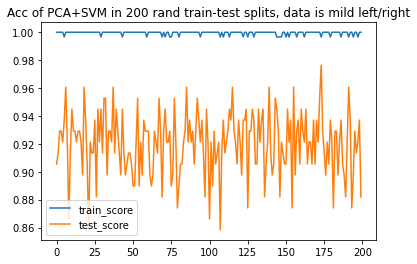

In [20]:
plt.figure()
result_df.plot()
plt.legend(loc="best")
plt.title("Acc of PCA+SVM in 200 rand train-test splits, data is mild left/right")
# plt.savefig("results/pca_svm_cv_acc_mild_0707.png")